In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
print("Done")

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
Done


# Constants 👨‍🎓

In [2]:
PATH = "../input/house-prices-advanced-regression-techniques"
TRAIN_PATH = os.path.join(PATH, "train.csv")
TEST_PATH = os.path.join(PATH, "test.csv")
SUBMISSION_PATH = os.path.join(PATH, "sample_submission.csv")

SALE_PRICE = "SalePrice"
LOT_AREA = "LotArea"
OVERALL_QUAL = "OverallQual"
GRLIVAREA = "GrLivArea"
GARAGE_YR_BLT = "GarageYrBlt"
MAS_VNR_AREA = "MasVnrArea"	
TOTAL_BSMT_SF = "TotalBsmtSF"
GARAGE_CARS = "GarageCars"
GARAGE_AREA = "GarageArea"

# Functions 🧮

**🟦EN** Function that we use later to see the characteristics of the data such as missing values (NaN), all of features and number, records and columns

**🟥ES** Función que usamos más tarde para ver las características de los datos, como valores faltantes (NaN), todas las características y el número, registros y columnas

In [3]:
def data_description(df):
    print("Data description")
    print(f"Total number of records {df.shape[0]}")
    print(f'number of features {df.shape[1]}\n\n')
    columns = df.columns
    data_type = []
    
    # Get the datatype of features
    for col in df.columns:
        data_type.append(df[col].dtype)
        
    n_uni = df.nunique()
    # Number of NaN values
    n_miss = df.isna().sum()
    
    names = list(zip(columns, data_type, n_uni, n_miss))
    variable_desc = pd.DataFrame(names, columns=["Name","Type","Unique levels","Missing"])
    pd.set_option('display.max_rows', None)
    print(variable_desc)

In [4]:
def show_regplot(df, col1, col2, title = ""): 
    plt.figure(figsize = (10, 5))
    plt.title(title)
    sns.regplot(data = df, x = col1, y = col2, line_kws={"color": "green"})

In [5]:
def show_missing_values(df):
    nan_values = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum() / df.count() * 100)
    missing = pd.concat([nan_values, percent], keys = ["Nan values", "%"], axis = 1)
    return missing

# Data processing

In [6]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)
submission_data = pd.read_csv(SUBMISSION_PATH)

In [7]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
data_description(train_data)

Data description
Total number of records 1460
number of features 81


             Name     Type  Unique levels  Missing
0              Id    int64           1460        0
1      MSSubClass    int64             15        0
2        MSZoning   object              5        0
3     LotFrontage  float64            110      259
4         LotArea    int64           1073        0
5          Street   object              2        0
6           Alley   object              2     1369
7        LotShape   object              4        0
8     LandContour   object              4        0
9       Utilities   object              2        0
10      LotConfig   object              5        0
11      LandSlope   object              3        0
12   Neighborhood   object             25        0
13     Condition1   object              9        0
14     Condition2   object              8        0
15       BldgType   object              5        0
16     HouseStyle   object              8        0
17    Overal

In [9]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
data_description(test_data)

Data description
Total number of records 1459
number of features 80


             Name     Type  Unique levels  Missing
0              Id    int64           1459        0
1      MSSubClass    int64             16        0
2        MSZoning   object              5        4
3     LotFrontage  float64            115      227
4         LotArea    int64           1106        0
5          Street   object              2        0
6           Alley   object              2     1352
7        LotShape   object              4        0
8     LandContour   object              4        0
9       Utilities   object              1        2
10      LotConfig   object              5        0
11      LandSlope   object              3        0
12   Neighborhood   object             25        0
13     Condition1   object              9        0
14     Condition2   object              5        0
15       BldgType   object              5        0
16     HouseStyle   object              7        0
17    Overal

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

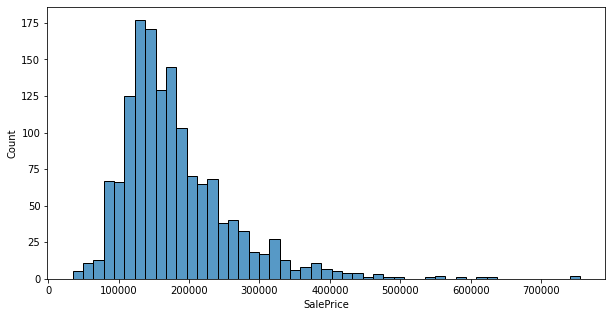

In [11]:
plt.figure(figsize = (10,5))
sns.histplot(data = train_data, x = "SalePrice")

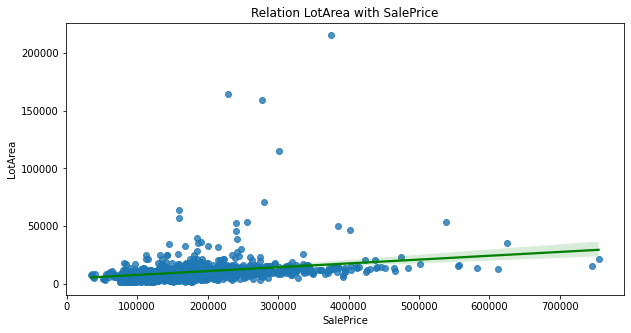

In [12]:
show_regplot(train_data, SALE_PRICE, LOT_AREA, "Relation LotArea with SalePrice")

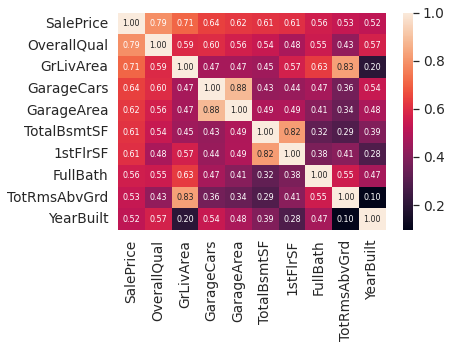

In [13]:
correlation = train_data.corr()

k = 10
cols = correlation.nlargest(k, SALE_PRICE)[SALE_PRICE].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


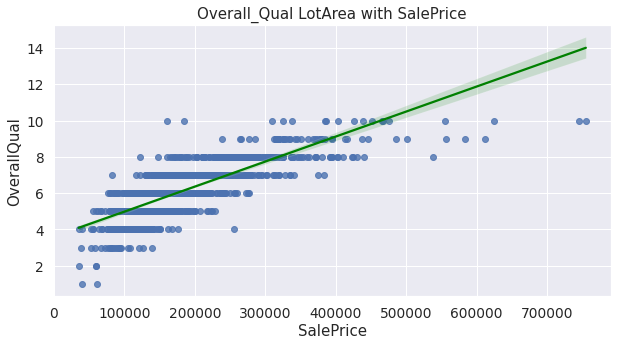

In [14]:
show_regplot(train_data, SALE_PRICE, OVERALL_QUAL, "Overall_Qual LotArea with SalePrice")

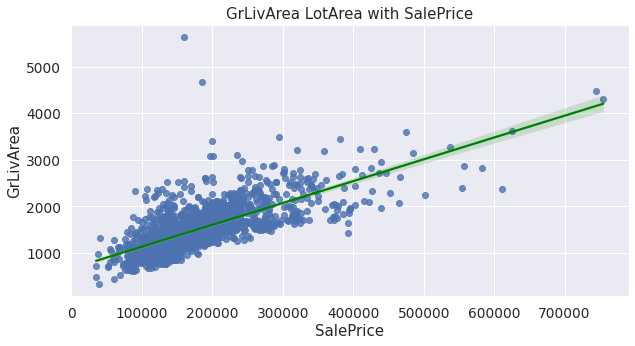

In [15]:
show_regplot(train_data, SALE_PRICE, GRLIVAREA, "GrLivArea LotArea with SalePrice")

In [16]:
index_corr = correlation[correlation[SALE_PRICE] > 0.4].index
print(index_corr)

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice'],
      dtype='object')


In [17]:
train_data = train_data[index_corr]
index_corr = index_corr.drop(SALE_PRICE)
test_data = test_data[index_corr]
print("Done")

Done


In [18]:
train_missing = show_missing_values(train_data)

In [19]:
train_missing.head(15)

,Nan values,%
GarageYrBlt,81,5.873822
MasVnrArea,8,0.550964
OverallQual,0,0.000000
YearBuilt,0,0.000000
YearRemodAdd,0,0.000000
TotalBsmtSF,0,0.000000
1stFlrSF,0,0.000000
GrLivArea,0,0.000000
FullBath,0,0.000000
TotRmsAbvGrd,0,0.000000


In [20]:
test_missing = show_missing_values(test_data)
test_missing.head(15)

,Nan values,%
GarageYrBlt,78,5.648081
MasVnrArea,15,1.038781
TotalBsmtSF,1,0.068587
GarageCars,1,0.068587
GarageArea,1,0.068587
OverallQual,0,0.000000
YearBuilt,0,0.000000
YearRemodAdd,0,0.000000
1stFlrSF,0,0.000000
GrLivArea,0,0.000000


In [21]:
print(train_data[GARAGE_YR_BLT].dtype)
print(train_data[GARAGE_YR_BLT][:10])

float64
0    2003.0
1    1976.0
2    2001.0
3    1998.0
4    2000.0
5    1993.0
6    2004.0
7    1973.0
8    1931.0
9    1939.0
Name: GarageYrBlt, dtype: float64


In [22]:
train_data[GARAGE_YR_BLT] = train_data[GARAGE_YR_BLT].fillna(train_data[GARAGE_YR_BLT].mean())
test_data[GARAGE_YR_BLT] = test_data[GARAGE_YR_BLT].fillna(test_data[GARAGE_YR_BLT].mean())

train_data[MAS_VNR_AREA] = train_data[MAS_VNR_AREA].fillna(train_data[MAS_VNR_AREA].mean())
test_data[MAS_VNR_AREA] = test_data[MAS_VNR_AREA].fillna(test_data[MAS_VNR_AREA].mean())

In [23]:
test_data[TOTAL_BSMT_SF] = test_data[TOTAL_BSMT_SF].fillna(test_data[TOTAL_BSMT_SF].mean())
test_data[GARAGE_CARS] = test_data[GARAGE_CARS].fillna(test_data[GARAGE_CARS].mean())
test_data[GARAGE_AREA] = test_data[GARAGE_AREA].fillna(test_data[GARAGE_AREA].mean())
print(test_data.isna().sum())

OverallQual     0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
Fireplaces      0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64


# Train 🧠

In [24]:
print(train_data.columns)
print(train_data.shape)

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice'],
      dtype='object')
(1460, 14)


In [25]:
X = train_data.copy()
X.drop(SALE_PRICE, axis = 1, inplace = True)
Y = train_data.SalePrice.values

print("Done")

Done


In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

print("Done")

Done


In [27]:
param = {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls'}

In [28]:
xg_reg = XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

gb_reg = GradientBoostingRegressor(**param)

rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.1, n_estimators=500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [29]:
classifiers = [
    # ('DecisionTreeRegressor', dtreg),
    ('Gradient Boosting Regression', gb_reg),
    ('XGBRegressor', xg_reg),
    # ('Lasso',lasso),
    ('RandomForestRegressor', rfr),
    # ('Support Vector Machine Regression', svr),
    ('LightGBM',model_lgb)
]

In [30]:
for met_name, met in classifiers:
    met.fit(X_train, Y_train)
    
    pred = met.predict(X_val)
    pred = pred.reshape(-1,1)
    
    error = metrics.mean_squared_error(Y_val, pred)
    
    print('{:s} MSE : {:.3f}'.format(met_name, error))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


Gradient Boosting Regression MSE : 865126754.135
[10:42:16] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor MSE : 6621942981.899
RandomForestRegressor MSE : 1154967312.764
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
LightGBM MSE : 1357285975.133


# Submission 📩

In [31]:
pred_submission = model_lgb.predict(test_data)

In [32]:
submission_data[SALE_PRICE] = pred_submission

In [33]:
submission_data.to_csv("submission.csv", index = False)